## Library Setup

In [91]:
import os

import warnings

import numpy as np
import pandas as pd
from category_encoders import (
    BackwardDifferenceEncoder,
    BaseNEncoder,
    BinaryEncoder,
    CatBoostEncoder,
    CountEncoder,
    GLMMEncoder,
    HelmertEncoder,
    JamesSteinEncoder,
    LeaveOneOutEncoder,
    MEstimateEncoder,
    SummaryEncoder,
    TargetEncoder,
    WOEEncoder,
)
from sklearn import set_config
from sklearn.base import clone as model_clone
from sklearn.cluster import *
from sklearn.compose import *
from sklearn.cross_decomposition import *
from sklearn.decomposition import *
from sklearn.ensemble import *
from sklearn.feature_selection import *
from sklearn.gaussian_process import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.multioutput import *
from sklearn.multiclass import *
from sklearn.naive_bayes import *
from sklearn.neighbors import *
from sklearn.neural_network import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.svm import *
from sklearn.tree import *
from sklearn.utils import *
from sklearn.dummy import *
from sklearn.semi_supervised import *
from sklearn.discriminant_analysis import *
from collections import Counter

from xgboost import XGBClassifier, XGBRFClassifier

from sklearn.calibration import *
import joblib

pd.options.display.max_columns = 50
set_config(display="diagram")
warnings.filterwarnings("ignore")
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import InstanceHardnessThreshold
from imblearn.over_sampling import ADASYN,SMOTE,RandomOverSampler,SVMSMOTE,SMOTENC,SMOTEN,BorderlineSMOTE,KMeansSMOTE

plt.style.use('fivethirtyeight')

%matplotlib inline
import seaborn as sns

sns.set()
from joblib import parallel_backend
from joblib.memory import Memory


def allow_stopping(func):
    def wrapper():
        try:
            value = func()
            return value
            # gc.collect()
        except KeyboardInterrupt as e:
            print("Program Stopped")
        gc.collect()

    return wrapper


import warnings

warnings.filterwarnings("ignore")

__refresh__ = 1


def run_if_refresh(func):
    def wrapper():
        global __refresh__
        if __refresh__ == 1:
            value = func()
            return value
        else:
            print(
                "Using Cache, Set Refresh to '__refresh__=1' to regenerate "
                "the output of this  function"
            )

    return wrapper


def gen_train_test(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=10
    )
    return X_train, X_test, y_train, y_test


def categorise_input(X: pd.DataFrame):
    X.loc[:, nominal + ordinal] = X.loc[:, nominal + ordinal].astype("category")
    return X

KAGGLE_ENV = 1
cwd = os.path.abspath(os.getcwd())
if "mlop3n/Pycharm" in cwd:
    KAGGLE_ENV = 0
    
if KAGGLE_ENV==1:
    
    categoriser = FunctionTransformer(categorise_input, feature_names_out="one-to-one")
categoriser = FunctionTransformer(categorise_input, feature_names_out="one-to-one")


def quick_test(X):
    clfs = [
        RandomForestClassifier(class_weight="balanced_subsample", random_state=42),
        DecisionTreeClassifier(class_weight="balanced", random_state=42),
        HistGradientBoostingClassifier(random_state=42),
        LogisticRegressionCV(max_iter=1000, class_weight="balanced", random_state=42),
    ]
    y = raw_data.target
    X_train, X_test, y_train, y_test = gen_train_test(X, y, test_size=0.5)
    for clf in clfs:
        y_pred = clf.fit(X_train, y_train).predict(X_test)
        score = f1_score(y_test, y_pred, average="macro")
        print(f"{clf.__class__.__name__} :: {score}")


def find_correlated_features(df, threshold=0.8):
    correlated_features = set()
    correlation_matrix = df.corr()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
    return list(correlated_features)

        
"""
PCA MCA Equivalent
"""

# df = raw_data
def MCA(df):
    tmp_nom = np.zeros(df.shape[0])
    for c in nominal:
        nom_f = df[c]
        nom_f_vc = nom_f.value_counts()    
        nom_f_ohe = pd.get_dummies(nom_f)
        nom_f_vc_pk = nom_f_vc/df.shape[0]
        for ci in nom_f_ohe.columns:
            nom_f_ohe[ci] = (nom_f_ohe[ci]/nom_f_vc_pk[ci])-1
        tmp_nom = np.c_[tmp_nom,nom_f_ohe.to_numpy()]
        # break
    final_tmp_nom = tmp_nom[:,1:]
    dime = PCA(n_components=50,svd_solver='full',)
    final_nome_t  = dime.fit_transform(final_tmp_nom)
    return final_nome_t

        
"""
Binary Target Distributions
"""

def binary_target_dist(df):
    bin_target_0 = pd.DataFrame(columns=binary, index=[0,1,2])
    bin_target_1 = pd.DataFrame(columns=binary, index=[0,1,2])
    for c in binary:
        target_census = df.target.value_counts().to_dict()    
        f = df.groupby([c])['target'].value_counts().sort_index().unstack().transpose()
        # print(f[0])
        bin_target_0[c] = f[0]
        bin_target_1[c] = f[1]
    for i in range(3):
        bin_target_0.loc[i,:] = bin_target_0.loc[i,:] / target_census[i]
        bin_target_1.loc[i,:] = bin_target_1.loc[i,:] / target_census[i]
    return bin_target_0, bin_target_1

def m_VI(df):
    VI = np.linalg.inv(np.cov(df, rowvar=False))
    return VI

In [2]:
class ColumnSelectors:
    def __init__(self, default=None):
        self.dtype_info = {
            "binary__v_1": "Binary",
            "binary__v_11": "Binary",
            "binary__v_14": "Binary",
            "binary__v_26": "Binary",
            "binary__v_27": "Binary",
            "binary__v_28": "Binary",
            "binary__v_30": "Binary",
            "binary__v_9": "Binary",
            "nominal__v_12": "Nominal",
            "nominal__v_18": "Nominal",
            "nominal__v_20": "Nominal",
            "nominal__v_21": "Nominal",
            "nominal__v_25": "Nominal",
            "nominal__v_3": "Nominal",
            "nominal__v_32": "Nominal",
            "nominal__v_4": "Nominal",
            "ordinal__v_0": "Ordinal",
            "ordinal__v_10": "Ordinal",
            "ordinal__v_13": "Ordinal",
            "ordinal__v_15": "Ordinal",
            "ordinal__v_17": "Ordinal",
            "ordinal__v_19": "Ordinal",
            "ordinal__v_22": "Ordinal",
            "ordinal__v_23": "Ordinal",
            "ordinal__v_24": "Ordinal",
            "ordinal__v_29": "Ordinal",
            "ordinal__v_31": "Ordinal",
            "ordinal__v_33": "Ordinal",
            "ordinal__v_5": "Ordinal",
            "ordinal__v_6": "Ordinal",
            "ratio__v_16": "Ratio",
            "ratio__v_2": "Ratio",
            "ratio__v_34": "Ratio",
            "ratio__v_35": "Ratio",
            "ratio__v_36": "Ratio",
            "ratio__v_37": "Ratio",
            "ratio__v_38": "Ratio",
            "ratio__v_39": "Ratio",
            "ratio__v_40": "Ratio",
            "ratio__v_7": "Ratio",
            "ratio__v_8": "Ratio",
        }

        self.ordinal_cols = [
            i for i in self.dtype_info if self.dtype_info[i] == "Ordinal"
        ]
        self.nominal_cols = [
            i for i in self.dtype_info if self.dtype_info[i] == "Nominal"
        ]
        self.binary_cols = [
            i for i in self.dtype_info if self.dtype_info[i] == "Binary"
        ]
        self.ratio_cols = [i for i in self.dtype_info if self.dtype_info[i] == "Ratio"]
        self.ordinal = make_column_selector(
            pattern="|".join(self.ordinal_cols),
        )
        self.nominal = make_column_selector(
            pattern="|".join(self.nominal_cols),
        )
        self.binary = make_column_selector(
            pattern="|".join(self.binary_cols),
        )
        self.ratio = make_column_selector(
            pattern="|".join(self.ratio_cols),
        )

    def ordinal_selector(self):
        return self.ordinal

    def nominal_selector(self):
        return self.nominal

    def binary_selector(self):
        return self.binary

    def ratio_selector(self):
        return self.ratio

    def categorise_data(self, df: pd.DataFrame = None):
        """
        Categorise Data based on given data
        :params df : pandas.Dataframe
        """
        if isinstance(df, pd.DataFrame):
            ordinal_data = df.loc[:, self.ordinal_cols]
            nominal_data = df.loc[:, self.nominal_cols]
            binary_data = df.loc[:, self.binary_cols]
            ratio_data = df.loc[:, self.ratio_cols]
        else:
            print("Please provide valid Data")
        return ordinal_data, nominal_data, binary_data, ratio_data


column_directory = ColumnSelectors()

In [3]:
DATA_PATH = "/kaggle/input/students-drop-out-prediction/"
DATA_SAVE_PATH = "/kaggle/working/"
TRAIN_DATA = "train.csv"
TEST_DATA = "test.csv"
KAGGLE_ENV = 1
BENCHMARK_INPUT = '/kaggle/input/sub-sample/'

cwd = os.path.abspath(os.getcwd())
if "mlop3n/Pycharm" in cwd:
    KAGGLE_ENV = 0

if KAGGLE_ENV == 0:
    LOCAL_PATH = "../data"
    DATA_PATH = LOCAL_PATH + DATA_PATH
    DATA_SAVE_PATH = LOCAL_PATH + DATA_SAVE_PATH
    BENCHMARK_INPUT = LOCAL_PATH + BENCHMARK_INPUT


def write_raw_data(raw_data: pd.DataFrame, raw_data_eval: pd.DataFrame):
    global DATA_SAVE_PATH
    raw_data.to_parquet(DATA_SAVE_PATH + "train.parquet")
    raw_data_eval.to_parquet(DATA_SAVE_PATH + "test.parquet")


# TODO rerun this script to rename the target column


def reload_raw_data():
    global DATA_SAVE_PATH
    raw_data = pd.read_parquet(DATA_SAVE_PATH + "train.parquet")
    raw_data_eval = pd.read_parquet(DATA_SAVE_PATH + "test.parquet")
    return raw_data, raw_data_eval

benchmark = pd.read_csv(BENCHMARK_INPUT+'sample.csv')

def make_submission(y):
    trial=0
    y_df = pd.DataFrame(y, columns=["label"])
    y_df.index.rename('id',inplace=True)
    y_df.to_csv(
        DATA_SAVE_PATH + "submission.csv",
    )
    if trial==0:
        benchmark.to_csv(DATA_SAVE_PATH+ "submission.csv")

@run_if_refresh
def rename_columns_with_dtype(DATA_PATH=DATA_PATH, DATA_SAVE_PATH=DATA_SAVE_PATH):
    raw_data = pd.read_csv(DATA_PATH + TRAIN_DATA, index_col=0)
    raw_data_eval = pd.read_csv(DATA_PATH + TEST_DATA, index_col=0)

    raw_dtypes_info = {}
    saved_dtypes_info = column_directory.dtype_info
    for k, v in saved_dtypes_info.items():
        tmp = k.split("__")
        data_type = tmp[0]
        column_name = tmp[1]
        raw_dtypes_info[column_name] = k

    raw_data.rename(columns=raw_dtypes_info, inplace=True)
    raw_data_eval.rename(columns=raw_dtypes_info, inplace=True)
    raw_data.rename(columns={"label": "target"}, inplace=True)
    write_raw_data(raw_data, raw_data_eval)
    return raw_data, raw_data_eval


# rename_columns_with_dtype()
def reset_data():
    return rename_columns_with_dtype()
    

In [4]:
raw_data, raw_data_eval = reset_data()

In [5]:
X = raw_data.drop(["target"], axis=1)
y = raw_data.target

In [6]:
ordinal = column_directory.ordinal_cols
nominal = column_directory.nominal_cols
binary = column_directory.binary_cols
ratios = column_directory.ratio_cols

ordinal_data, nominal_data, binary_data, ratios_data = column_directory.categorise_data(
    raw_data
)
(
    ordinal_data_eval,
    nominal_data_eval,
    binary_data_eval,
    ratios_data_eval,
) = column_directory.categorise_data(raw_data_eval)

In [7]:
def baseline(raw_data=raw_data, test_size=0.5):
    X = raw_data.drop(["target"], axis=1)
    y = raw_data.target
    # quick_test(X)
    X_train, X_test, y_train, y_test = gen_train_test(X, y, test_size=test_size)

    random_forest = BalancedRandomForestClassifier(random_state=10)
    tmp_clf = make_pipeline(
        RFE(
            estimator=BalancedRandomForestClassifier(random_state=42),
            n_features_to_select=50,
        ),
        AdaBoostClassifier(
            base_estimator=random_forest, n_estimators=4, random_state=10
        ),
    )
    with parallel_backend("loky"):
        y_pred = tmp_clf.fit(X_train, y_train).predict(X_test)
        print(classification_report(y_test, y_pred))
        scores = cross_validate(
            tmp_clf,
            X,
            y,
            cv=StratifiedKFold(n_splits=4),
            n_jobs=-1,
            scoring="f1_macro",
            return_train_score=True,
        )
        print("F1_Train", scores["train_score"].mean())
        print("F1_Test", scores["test_score"].mean())


# baseline()

## Transformations
 - <mark>__Scale Down Ordinal Data By Substracting all samples with Global Feature Minimum__</mark>
 - <mark>__Sort Columns by Name for better visibility__</mark>
 - <mark>__Ordinally Encode Nominal Data to reduce categorical distance within a feature__</mark>
 - <mark>__Add a Column - Sum of all Binary Features along x-axis__</mark>
 - <mark>__Standardise the Ratio Features using Quantile Transformeer__</mark>

In [8]:
__refresh__ = 1
raw_data, raw_data_eval = reset_data()

# @run_if_refresh
def update_ordinal_data(raw_data=raw_data, raw_data_eval=raw_data_eval):
    categorical_columns = [ordinal, nominal]
    ordinal_data = raw_data.loc[:, ordinal].copy()
    ordinal_data_eval = raw_data_eval.loc[:, ordinal].copy()
    raw_data.loc[:, ordinal] = ordinal_data - ordinal_data.min()
    raw_data_eval.loc[:, ordinal] = ordinal_data_eval - ordinal_data.min()
    # update_categorical_data()
    # disp = raw_data.loc[:, ordinal].min().plot(color="r", rot=90)
    # disp = raw_data_eval.loc[:, ordinal].min().plot(rot=90)
    # write_raw_data(raw_data, raw_data_eval)
    return raw_data, raw_data_eval

# @run_if_refresh
def sort_columns_by_name(raw_data=raw_data, raw_data_eval=raw_data_eval):
    raw_data = raw_data.sort_index(axis=1)
    raw_data_eval = raw_data_eval.sort_index(axis=1)
    raw_data.to_parquet(DATA_SAVE_PATH + "train.parquet")
    raw_data_eval.to_parquet(DATA_SAVE_PATH + "test.parquet")
    return raw_data, raw_data_eval

# @run_if_refresh
def ordinally_encode_nominal_data(raw_data=raw_data, raw_data_eval=raw_data_eval):
    ordinal_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=125)
    nominal_enc_data = ordinal_enc.fit_transform(raw_data.loc[:, nominal])
    nominal_enc_data_eval = ordinal_enc.transform(raw_data_eval.loc[:, nominal])
    raw_data.loc[:, nominal] = nominal_enc_data
    raw_data_eval.loc[:, nominal] = nominal_enc_data_eval
    # write_raw_data(raw_data, raw_data_eval)
    return raw_data, raw_data_eval
# @run_if_refresh
def binary_feature_sum(raw_data=raw_data, raw_data_eval=raw_data_eval):
    raw_data["binary_sum"] = raw_data.loc[:, binary].sum(axis=1)/7
    raw_data_eval["binary_sum"] = raw_data_eval.loc[:, binary].sum(axis=1)/7
    # write_raw_data(raw_data, raw_data_eval)
    return raw_data, raw_data_eval

# @run_if_refresh
def standardise_ratio_features(
    raw_data=raw_data.copy(), raw_data_eval=raw_data_eval.copy()
):
    # Load Data
    payload = raw_data.loc[:, ratios]
    payload_eval = raw_data_eval.loc[:, ratios]
    mscaler = MinMaxScaler()
    # Apply Scaling
    payload_t = mscaler.fit_transform(payload)
    payload_eval_t = mscaler.transform(payload_eval)
    # New Column Names
    new_ordinal_col_names = mscaler.get_feature_names_out()
    new_ordinal_col_names = [x.replace(".", "_") for x in new_ordinal_col_names]
    # Create Dataframe with new features to concatenate
    tmp_raw_data = pd.DataFrame(
        payload_t, columns=new_ordinal_col_names, index=raw_data.index
    )
    tmp_raw_data_eval = pd.DataFrame(
        payload_eval_t, columns=new_ordinal_col_names, index=raw_data_eval.index
    )
    # Concatenate in place
    raw_data = pd.concat([tmp_raw_data, raw_data.drop(ratios, axis=1)], axis=1)
    raw_data_eval = pd.concat(
        [tmp_raw_data_eval, raw_data_eval.drop(ratios, axis=1)], axis=1
    )
    # Write modified data to disk
    # write_raw_data(raw_data, raw_data_eval)
    # return raw_data
    return raw_data, raw_data_eval
    
def ordinal_norm(df):
    scaler = MinMaxScaler()
    tmp_ord = scaler.fit_transform(df.loc[:,ordinal])
    tmp_ord_sq= tmp_ord @ tmp_ord.T 
    tmp_ord_nom = scaler.fit_transform(abs(np.sqrt(tmp_ord_sq.mean(axis=1))).reshape(-1,1))
    return tmp_ord_nom

def gen_ord_norm(raw_data=raw_data, raw_data_eval=raw_data_eval):
    raw_data['ord_norm'] = ordinal_norm(raw_data)
    raw_data_eval['ord_norm'] = ordinal_norm(raw_data_eval)
    return raw_data, raw_data_eval

def gen_binary_literal(row):
    bin_chr = [str(row[b]) for b in binary]
    b_l = ""
    for c in bin_chr:
        b_l+=c
    row.bin_literal = int(b_l,2)/255
    return row

def add_literal_to_data(raw_data, raw_data_eval):
    b_lit_train = pd.DataFrame(columns=["bin_literal"], index=raw_data.index)
    b_lit_eval  = pd.DataFrame(columns=["bin_literal"], index=raw_data_eval.index)
    raw_data['bin_literal']  = "0"
    raw_data_eval['bin_literal']  = "0"
    raw_data = raw_data.apply(gen_binary_literal,axis=1)
    raw_data_eval= raw_data_eval.apply(gen_binary_literal,axis=1)
    return raw_data, raw_data_eval

@run_if_refresh
def apply_transformations():
    raw_data, raw_data_eval = reset_data()

    raw_data, raw_data_eval = update_ordinal_data(raw_data, raw_data_eval)
    # raw_data, raw_data_eval = reload_raw_data()
    raw_data, raw_data_eval = sort_columns_by_name(raw_data, raw_data_eval)
    # raw_data, raw_data_eval = reload_raw_data()
    raw_data, raw_data_eval = ordinally_encode_nominal_data(raw_data, raw_data_eval)    
    # raw_data, raw_data_eval = reload_raw_data()
    raw_data, raw_data_eval = binary_feature_sum(raw_data, raw_data_eval)
    # raw_data, raw_data_eval = reload_raw_data()
    raw_data, raw_data_eval = standardise_ratio_features(raw_data, raw_data_eval)
    raw_data, raw_data_eval = gen_ord_norm(raw_data, raw_data_eval)
    raw_data, raw_data_eval = add_literal_to_data(raw_data, raw_data_eval)
    raw_data.sort_index(axis=1,inplace=True)
    raw_data_eval.sort_index(axis=1,inplace=True)
    write_raw_data(raw_data, raw_data_eval)
    
    
apply_transformations()
raw_data, raw_data_eval = reload_raw_data()


def refresh_data():
    global __refresh__
    __refresh__ = 1
    raw_data, raw_data_eval = reset_data()
    # rename_columns_with_dtype()
    apply_transformations()
    raw_data, raw_data_eval = reload_raw_data()
    __refresh__ = 0
    print("Data Refresh Success")
    return raw_data, raw_data_eval
    
# raw_data, raw_data_eval = refresh_data()

features = raw_data.drop(['target'],axis=1).columns

def create_target_encoding():
    new_column_names = []
    stubs = ["_0","_1","_2"]
    for c in ordinal+nominal:
        for _suffix in stubs:
            new_column_names.append(c+_suffix)
    df_train = pd.DataFrame(index=raw_data.index,columns=new_column_names)
    df_eval = pd.DataFrame(index=raw_data_eval.index,columns=new_column_names)
    target_census = raw_data.target.value_counts().to_dict()    
    for c in ordinal+nominal:
        target_counts = raw_data.groupby(c)['target'].value_counts().unstack(fill_value=0)
        tf: pd.DataFrame = target_counts.loc[:,[0,1,2]]
        target_counts['sum'] = tf.sum(axis=1)
        target_counts['std'] = tf.std(axis=1)
        # target_counts['std'] = 
        # tf2=tf
        # for i in range(3):
        #     tf.loc[:,i] = tf.loc[:,i]/(target_census[i]-1)
        # tf2 = tf.subtract(target_counts['std'],axis='rows')
        tf2 = tf.divide((target_counts['sum']),axis='rows')
        target_map = {0:0,1:1,2:2}
        for val in target_map:
            mapping = defaultdict(int,tf2.to_dict()[target_map[val]])
            df_train[c+stubs[val]] = raw_data[c].map(mapping)
            df_eval[c+stubs[val]] = raw_data_eval[c].map(mapping)
    return df_train, df_eval

target_encoded_train, target_encoded_eval  = create_target_encoding()


ordinal = column_directory.ordinal_cols
nominal = column_directory.nominal_cols
binary = column_directory.binary_cols
ratios = column_directory.ratio_cols

ordinal_data, nominal_data, binary_data, ratios_data = column_directory.categorise_data(
    raw_data
)
(
    ordinal_data_eval,
    nominal_data_eval,
    binary_data_eval,
    ratios_data_eval,
) = column_directory.categorise_data(raw_data_eval)

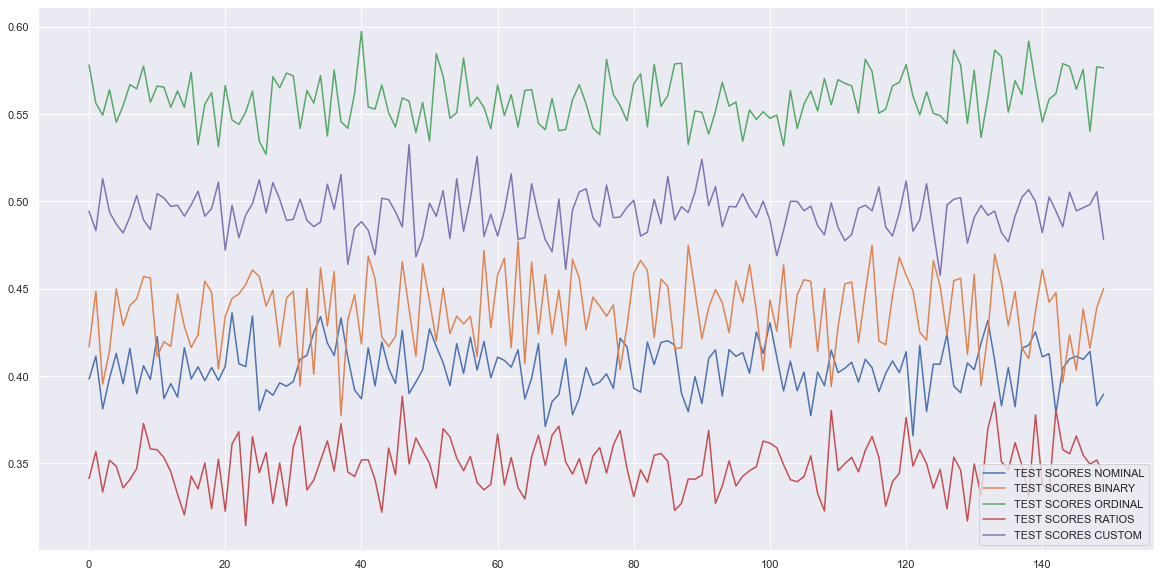

In [31]:
clf = DecisionTreeClassifier(class_weight='balanced')
REPEAT=50
disp = plt.figure(figsize=(20,10))
transformed_bin_scores = cross_validate(clf,nominal_data,raw_data.target, cv = RepeatedStratifiedKFold(n_splits=3,n_repeats=REPEAT), scoring='f1_macro', return_train_score=True)
disp = plt.plot(transformed_bin_scores['test_score'],label='Test Scores NOMINAL'.upper())
transformed_bin_scores = cross_validate(clf,binary_data,raw_data.target, cv = RepeatedStratifiedKFold(n_splits=3,n_repeats=REPEAT), scoring='f1_macro', return_train_score=True)
disp = plt.plot(transformed_bin_scores['test_score'],label='Test Scores BINARY'.upper())
transformed_bin_scores = cross_validate(clf,ordinal_data,raw_data.target, cv = RepeatedStratifiedKFold(n_splits=3,n_repeats=REPEAT), scoring='f1_macro', return_train_score=True)
disp = plt.plot(transformed_bin_scores['test_score'],label='Test Scores ORDINAL'.upper())
transformed_bin_scores = cross_validate(clf,ratios_data,raw_data.target, cv = RepeatedStratifiedKFold(n_splits=3,n_repeats=REPEAT), scoring='f1_macro', return_train_score=True)
disp = plt.plot(transformed_bin_scores['test_score'],label='Test Scores RATIOS'.upper())
custom_cols = ['bin_literal','binary_sum','ord_norm']
custom_data = raw_data.loc[:,custom_cols]
transformed_bin_scores = cross_validate(clf,custom_data,raw_data.target, cv = RepeatedStratifiedKFold(n_splits=3,n_repeats=REPEAT), scoring='f1_macro', return_train_score=True)
disp = plt.plot(transformed_bin_scores['test_score'],label='Test Scores CUSTOM'.upper())
# disp = plt.plot(transformed_bin_scores['train_score'],label='Train Scores 2')
s  = plt.legend()

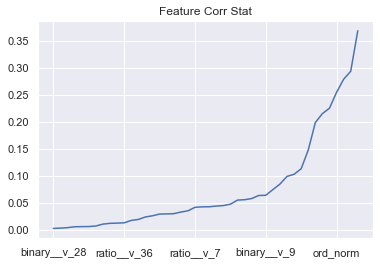

In [669]:
disp = raw_data.corrwith(raw_data.target, method='pearson').abs().sort_values().iloc[:-1].plot(title="Feature Corr Stat")

In [92]:
# Counter(clst.labels_)
"""
CountEncoding
"""
enc = CountEncoder()
n_enc = enc.fit_transform(nominal_data.astype('category'),raw_data.target)
transformer = make_pipeline(CountEncoder(cols=nominal),OneHotEncoder(handle_unknown='ignore'))
n_enc = transformer.fit_transform(nominal_data)
svd = TruncatedSVD(n_components=150, random_state=42,algorithm='arpack')
nenc_t = svd.fit_transform(n_enc)
X = raw_data.drop(['target'], axis=1)
X = nenc_t
# X = nominal_data
y = raw_data.target

X_train, X_test, y_train, y_test = gen_train_test(X,y, 0.5)
sampler_estimator = DecisionTreeClassifier(random_state=10, class_weight='balanced')
sampler = InstanceHardnessThreshold(random_state=42,estimator=sampler_estimator,cv=5,n_jobs=-1)
sampler = RandomOverSampler(random_state=10)

              precision    recall  f1-score   support

           0       0.43      0.36      0.39       621
           1       0.58      0.47      0.52       932
           2       0.24      0.43      0.31       345

    accuracy                           0.43      1898
   macro avg       0.42      0.42      0.41      1898
weighted avg       0.47      0.43      0.44      1898



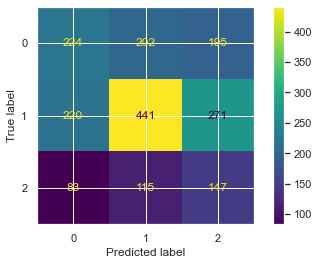

In [94]:
VI = m_VI(X_train)
model = KNeighborsClassifier(n_jobs=-1,n_neighbors=8,leaf_size=10,weights='distance', metric='mahalanobis', metric_params={'VI': VI})
clf = make_imb_pipeline(sampler, model)

with parallel_backend('loky'):
    # scores = cross_validate(clf,X,y,cv=RepeatedStratifiedKFold(n_repeats=3),scoring='f1_macro',)
    y_pred = clf.fit(X_train,y_train).predict(X_test)
print(classification_report(y_test,y_pred))
disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
# scores
# clf = KNeighborsClassifier(n_jobs=-1,n_neighbors=18,leaf_size=3,weights='distance', metric='mahalanobis', metric_params={'VI': np.cov(X_train, rowvar=False)})
# scores = cross_validate(clf_bag,X,y,cv=RepeatedStratifiedKFold(n_repeats=3),scoring='f1_macro',)
# model = KNeighborsClassifier(n_jobs=-1,n_neighbors=5,leaf_size=100)
# clf_ba# scores = cross_validate(clf_bag,X,y,cv=RepeatedStratifiedKFold(n_repeats=3),scoring='f1_macro',)
# scores['test_score'].mean()g = BaggingClassifier(base_estimator=clf,random_state=20,n_jobs=-1,n_estimators=50)
# print(scores['test_score'])

In [48]:
clst = KNeighborsTransformer(mode='distance',algorithm='ball_tree',n_jobs=-1,metric='mahalanobis', metric_params={'V': np.cov(X_train, rowvar=False)})

In [49]:
X_t = clst.fit_transform(X,y)

In [44]:
# clst.kneighbors_graph(X,n_neighbors=9)

<3796x3796 sparse matrix of type '<class 'numpy.float64'>'
	with 34164 stored elements in Compressed Sparse Row format>

In [46]:
# clst.get_feature_names_out()

array(['kneighborstransformer0', 'kneighborstransformer1',
       'kneighborstransformer2', ..., 'kneighborstransformer3793',
       'kneighborstransformer3794', 'kneighborstransformer3795'],
      dtype=object)

In [135]:
# b_tree = BallTree(binary_data,metric='mahalanobis', VI=m_VI(binary_data), leaf_size=10)


In [138]:
# b_tree.get_tree_stats()
kng = kneighbors_graph(b_tree,5)

In [11]:
dimx = PCA(n_components=3).fit_transform(nominal_data)
b_tree = KDTree(dimx,metric='minkowski',p=2,  leaf_size=3)
b_tree.get_tree_stats()

(0, 0, 0)

In [149]:
# np.sqrt(18980)

In [64]:

# svd.fit(n_enc)

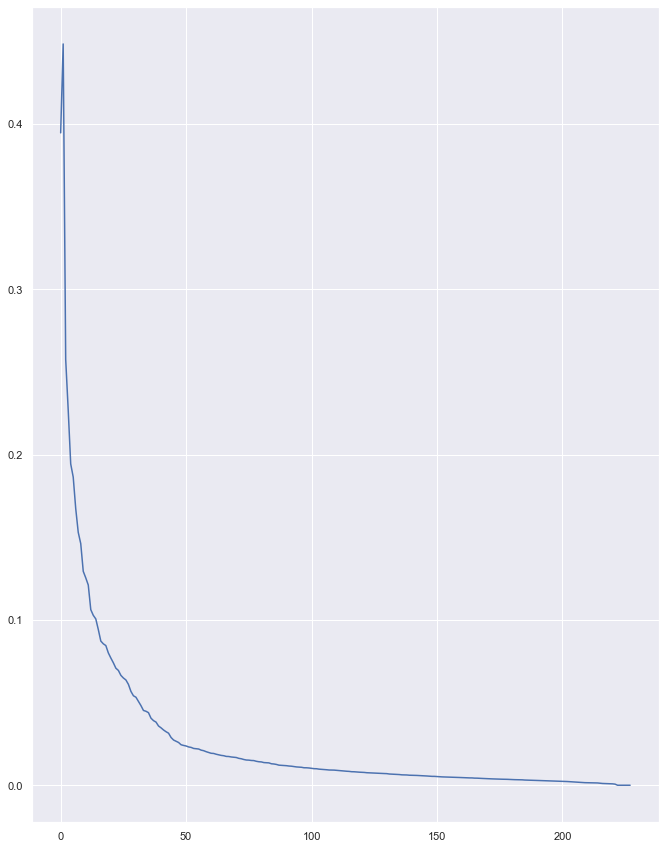

In [66]:
yx= svd.explained_variance_
names = svd.get_feature_names_out()
plt.figure(figsize=(10,15))
# plt.bar(x=np.arange(7),height=yx)
plt.plot(yx)

In [63]:
nenc_t

array([[ 1.59568555e+00, -5.97158817e-01,  2.89699670e-01, ...,
        -7.71504208e-01, -6.83833952e-01,  5.45313815e-01],
       [ 1.05714762e-02, -1.51928455e-03, -2.57670129e-02, ...,
        -2.57462328e-02, -4.02214456e-03,  2.71602653e-02],
       [ 1.43204434e+00, -5.88951495e-01, -4.65691610e-01, ...,
         8.65257368e-03, -1.43325810e-01, -2.82213946e-01],
       ...,
       [ 2.00275779e-01, -2.56693009e-01, -2.77119458e-01, ...,
         2.36346536e-01,  1.99653617e-01, -2.73359782e-01],
       [ 1.61830958e-01,  9.97886034e-02, -4.73731856e-01, ...,
         1.88550119e-01,  9.08540747e-03,  1.70384048e-02],
       [ 1.76094934e+00, -8.82531061e-01,  6.57598856e-02, ...,
         1.80826758e-02, -2.24392071e-01,  1.54198609e-01]])